In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os 
os.chdir('/content/drive/My Drive/objectDetection')

In [0]:
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -qq Cython contextlib2 pillow lxml matplotlib pycocotools

Selecting previously unselected package python-bs4.
(Reading database ... 144542 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpacking pyt

In [0]:
pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3MB 41kB/s 
     |████████████████████████████████| 3.8MB 61.9MB/s 
     |████████████████████████████████| 512kB 56.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=715963c98d34cecd155e56edf88a94c0e6402c746c06b5f99ec11dc26cd2ef3d
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc

In [0]:
from __future__ import division, print_function, absolute_import

import pandas as pd
import numpy as np
import csv

import re
import os
import io
import glob
import shutil
import urllib.request
import tarfile
import xml.etree.ElementTree as ET

import tensorflow.compat.v1 as tf
import cv2 

from PIL import Image
from collections import namedtuple, OrderedDict

from google.colab import files

In [0]:
print(tf.__version__)
os.chdir('/content/drive/My Drive/objectDetection')

1.15.0


In [0]:
def xml_to_csv(path):
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text,
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names

for label_path in ['train', 'test']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

label_map_path = os.path.join("label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(classes):
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)

Successfully converted train xml to csv.
Successfully converted test xml to csv.


In [0]:
# downloads the models
!git clone --q https://github.com/tensorflow/models.git

In [0]:
os.chdir('/content/drive/My Drive/objectDetection/models/research')
#/content/drive/My Drive/objectDetection/object_detection
# compils the proto buffers
!protoc object_detection/protos/*.proto --python_out=.
# exports PYTHONPATH environment var with research and slim paths
os.environ['PYTHONPATH'] += ':./:./slim/'

In [0]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
os.chdir('/content/drive/My Drive/objectDetection/models/research')
# testing the model builder
!python3 object_detection/builders/model_builder_test.py

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_experimental_model
[       OK ] ModelBuilderTest.test_create_experimental_model
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       OK ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[       OK ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_wi

In [0]:
from object_detection.utils import dataset_util


#change this to the base directory where your data/ is 
data_base_url = '/content/drive/My Drive/objectDetection/'

#location of images
test_dir = data_base_url +'images/test'
train_dir = data_base_url +'images/train'

def class_text_to_int(row_label):
  if row_label == 'apple':
    return 1
  else:
    None

def split(df, group):
  data = namedtuple('data', ['filename', 'object'])
  gb = df.groupby(group)
  return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf_example(group, path):
	with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
	  encoded_jpg = fid.read()
	encoded_jpg_io = io.BytesIO(encoded_jpg)
	image = Image.open(encoded_jpg_io)
	width, height = image.size
	filename = group.filename.encode('utf8')
	image_format = b'jpg'
	xmins = []
	xmaxs = []
	ymins = []
	ymaxs = []
	classes_text = []
	classes = []

	for index, row in group.object.iterrows():
		xmins.append(row['xmin'] / width)
		xmaxs.append(row['xmax'] / width)
		ymins.append(row['ymin'] / height)
		ymaxs.append(row['ymax'] / height)
		classes_text.append(row['class'].encode('utf8'))
		classes.append(class_text_to_int(row['class']))

	tf_example = tf.train.Example(features=tf.train.Features(feature={
		'image/height': dataset_util.int64_feature(height),
		'image/width': dataset_util.int64_feature(width),
		'image/filename': dataset_util.bytes_feature(filename),
		'image/source_id': dataset_util.bytes_feature(filename),
		'image/encoded': dataset_util.bytes_feature(encoded_jpg),
		'image/format': dataset_util.bytes_feature(image_format),
		'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
		'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
		'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
		'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
		'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
		'image/object/class/label': dataset_util.int64_list_feature(classes),
		}))
	return tf_example
#creates tfrecord for both csv's
for csv in ['train', 'test']:
  writer = tf.io.TFRecordWriter(data_base_url + csv + '.record')
  if csv=='train':
      path = os.path.join(train_dir)
  else:
      path=os.path.join(test_dir)
  examples = pd.read_csv(data_base_url + csv + '.csv')
  grouped = split(examples, 'filename')
  for group in grouped:
    tf_example = create_tf_example(group, path)
    writer.write(tf_example.SerializeToString())
    
  writer.close()
  output_path = os.path.join(os.getcwd(), data_base_url + csv + '.record')
  print('Successfully created the TFRecords: {}'.format(data_base_url +csv + '.record'))

Successfully created the TFRecords: /content/drive/My Drive/objectDetection/train.record
Successfully created the TFRecords: /content/drive/My Drive/objectDetection/test.record


In [0]:
# Some models to train on
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
    },
}

# Select a model from `MODELS_CONFIG`.
# I chose ssd_mobilenet_v2 for this project, you could choose any
selected_model = 'ssd_mobilenet_v2'

In [0]:
#the distination folder where the model will be saved
#change this if you have a different working dir
DEST_DIR = '/content/drive/My Drive/objectDetection/models/research/pretrained_model'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

#selecting the model
MODEL_FILE = MODEL + '.tar.gz'

#creating the downlaod link for the model selected
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

#checks if the model has already been downloaded, download it otherwise
if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

#unzipping the model and extracting its content
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

# creating an output file to save the model while training
os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

In [0]:
os.chdir('/content/drive/My Drive/objectDetection/models/research')
#path to the config file
!cat object_detection/samples/configs/ssd_mobilenet_v2_coco.config




# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 1
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspec

In [0]:
#path to the config file
%%writefile object_detection/samples/configs/ssd_mobilenet_v2_coco.config


# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 1
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
        aspect_ratios: 0.3333
      }
    }
    image_resizer {
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    box_predictor {
      convolutional_box_predictor {
        min_depth: 0
        max_depth: 0
        num_layers_before_predictor: 0
        use_dropout: true
        dropout_keep_probability: 0.8
        kernel_size: 1
        box_code_size: 4
        apply_sigmoid_to_scores: false
        conv_hyperparams {
          activation: RELU_6,
          regularizer {
            l2_regularizer {
              weight: 0.00004
            }
          }
          initializer {
            truncated_normal_initializer {
              stddev: 0.03
              mean: 0.0
            }
          }
          batch_norm {
            train: true,
            scale: true,
            center: true,
            decay: 0.9997,
            epsilon: 0.001,
          }
        }
      }
    }
    feature_extractor {
      type: 'ssd_mobilenet_v2'
      min_depth: 16
      depth_multiplier: 1.0
      conv_hyperparams {
        activation: RELU_6,
        regularizer {
          l2_regularizer {
            weight: 0.00004
          }
        }
        initializer {
          truncated_normal_initializer {
            stddev: 0.03
            mean: 0.0
          }
        }
        batch_norm {
          train: true,
          scale: true,
          center: true,
          decay: 0.9997,
          epsilon: 0.001,
        }
      }
    }
    loss {
      classification_loss {
        weighted_sigmoid {
        }
      }
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      hard_example_miner {
        num_hard_examples: 3000
        iou_threshold: 0.99
        loss_type: CLASSIFICATION
        max_negatives_per_positive: 3
        min_negatives_per_image: 3
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    normalize_loss_by_num_matches: true
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SIGMOID
    }
  }
}

train_config: {
  batch_size: 24
  optimizer {
    rms_prop_optimizer: {
      learning_rate: {
        exponential_decay_learning_rate {
          initial_learning_rate: 0.004
          decay_steps: 800720
          decay_factor: 0.95
        }
      }
      momentum_optimizer_value: 0.9
      decay: 0.9
      epsilon: 1.0
    }
  }
  fine_tune_checkpoint: "/content/drive/My Drive/objectDetection/models/research/pretrained_model/model.ckpt"
  fine_tune_checkpoint_type:  "detection"
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 200000
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    ssd_random_crop {
    }
  }

   data_augmentation_options {
    random_adjust_contrast {
    }
  }
   data_augmentation_options {
    random_rgb_to_gray {
    }
  }

   data_augmentation_options {
    random_patch_gaussian {
    }
  }
}
train_input_reader: {
  tf_record_input_reader {
    input_path: "/content/drive/My Drive/objectDetection/train.record"
  }
  label_map_path: "/content/drive/My Drive/objectDetection/label_map.pbtxt"
}

eval_config: {
  num_examples: 1
  num_visualizations: 1
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "/content/drive/My Drive/objectDetection/test.record"
  }
  label_map_path: "/content/drive/My Drive/objectDetection/label_map.pbtxt"
  shuffle: false
  num_readers: 1
}

Overwriting object_detection/samples/configs/ssd_mobilenet_v2_coco.config


In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-04-01 12:56:29--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.70.189.149, 52.3.157.51, 52.70.195.119, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.70.189.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.4’

ngrok-stable-linux- 100%[===================>]  13.13M  5.14MB/s    in 2.6s    

2020-04-01 12:56:33 (5.14 MB/s) - ‘ngrok-stable-linux-amd64.zip.4’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
#the logs that are created while training 
LOG_DIR = "training/"
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
#The link to tensorboard.
#works after the training starts.
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://968727f3.ngrok.io


In [0]:
os.chdir('/content/drive/My Drive/objectDetection/models/research/')

In [0]:
!python object_detection/legacy/train.py --logtostderr --train_dir=training/ --pipeline_config_path=object_detection/samples/configs/ssd_mobilenet_v2_coco.config

INFO:tensorflow:global step 33673: loss = 1.6212 (0.630 sec/step)
I0401 17:52:01.494095 140457002706816 learning.py:507] global step 33673: loss = 1.6212 (0.630 sec/step)
INFO:tensorflow:global step 33674: loss = 1.7483 (0.554 sec/step)
I0401 17:52:02.049509 140457002706816 learning.py:507] global step 33674: loss = 1.7483 (0.554 sec/step)
INFO:tensorflow:global step 33675: loss = 1.0981 (0.595 sec/step)
I0401 17:52:02.645245 140457002706816 learning.py:507] global step 33675: loss = 1.0981 (0.595 sec/step)
INFO:tensorflow:global step 33676: loss = 1.6850 (0.605 sec/step)
I0401 17:52:03.251830 140457002706816 learning.py:507] global step 33676: loss = 1.6850 (0.605 sec/step)
INFO:tensorflow:global step 33677: loss = 1.6329 (0.574 sec/step)
I0401 17:52:03.827316 140457002706816 learning.py:507] global step 33677: loss = 1.6329 (0.574 sec/step)
INFO:tensorflow:global step 33678: loss = 2.3681 (0.667 sec/step)
I0401 17:52:04.495778 140457002706816 learning.py:507] global step 33678: loss 

In [0]:
!python object_detection/model_main.py \
    --pipeline_config_path=/content/drive/My\ Drive/objectDetection/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config \
    --model_dir=training/

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0331 20:13:01.277819 140445722748800 module_wrapper.py:139] From /content/drive/My Drive/objectDetection/models/research/object_detection/utils/config_util.py:102: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0331 20:13:01.283674 140445722748800 module_wrapper.py:139] From /content/drive/My Drive/objectDetection/models/research/object_detection/model_lib.py:628: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W0331 20:13:01.283902 140445722748800 model_lib.py:629] Forced number of epochs for all eval validations to be 1.

W0331 20:13:01.284097 140

In [0]:
output_directory = './fine_tunedmodel'

lst = os.listdir('training')
print(lst)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join('training', last_model)

['events.out.tfevents.1585512893.31bea5f2605f', 'events.out.tfevents.1585513604.af95399df642', 'events.out.tfevents.1585514489.af95399df642', 'events.out.tfevents.1585683581.3ed06592069b', 'events.out.tfevents.1585684309.3ed06592069b', 'events.out.tfevents.1585685628.3ed06592069b', 'pipeline.config', 'events.out.tfevents.1585746414.3f1bc145f75e', 'graph.pbtxt', 'model.ckpt-33158.data-00000-of-00001', 'model.ckpt-33158.index', 'model.ckpt-33158.meta', 'model.ckpt-34168.data-00000-of-00001', 'model.ckpt-34168.index', 'model.ckpt-34168.meta', 'model.ckpt-35171.data-00000-of-00001', 'model.ckpt-35171.index', 'model.ckpt-35171.meta', 'model.ckpt-36184.data-00000-of-00001', 'model.ckpt-36184.index', 'model.ckpt-36184.meta', 'model.ckpt-37198.data-00000-of-00001', 'model.ckpt-37198.index', 'model.ckpt-37198.meta', 'checkpoint']


In [0]:
!python /content/drive/My\ Drive/objectDetection/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/drive/My\ Drive/objectDetection/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0402 03:30:47.323463 139803824547712 module_wrapper.py:139] From /content/drive/My Drive/objectDetection/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0402 03:30:47.330385 139803824547712 module_wrapper.py:139] From /content/drive/My Drive/objectDetection/models/research/object_detection/exporter.py:402: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0402 03:30:47.330762 139803824547712 module_wrapper.py:139] From /content/drive/My Drive/objectDetection/models/research/object_detection/expor

In [0]:
#downloads the frozen model that is needed for inference
files.download(output_directory + '/frozen_inference_graph.pb')

MessageError: ignored

In [0]:
data_base_url='/content/drive/My Drive/objectDetection'
#download the label map
files.download(data_base_url + '/label_map.pbtxt')

MessageError: ignored

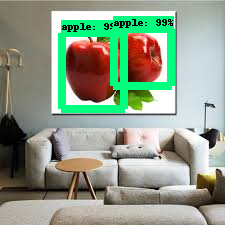

In [0]:
# Import packages
import os
import cv2
import numpy as np
import tensorflow as tf
import sys
from google.colab.patches import cv2_imshow

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

# Import utilites
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util


# Path to frozen detection graph .pb file, which contains the model that is used
# for object detection.
PATH_TO_CKPT = '/content/drive/My Drive/objectDetection/models/research/fine_tunedmodel/frozen_inference_graph.pb'

# Path to label map file
PATH_TO_LABELS = '/content/drive/My Drive/objectDetection/label_map.pbtxt'

# Path to image
PATH_TO_IMAGE = '/content/drive/My Drive/objectDetection/train/20.jpg'

# Number of classes the object detector can identify
NUM_CLASSES = 1

# Load the label map.
# Label maps map indices to category names, so that when our convolution
# network predicts `5`, we know that this corresponds to `king`.
# Here we use internal utility functions, but anything that returns a
# dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Load the Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

# Define input and output tensors (i.e. data) for the object detection classifier

# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

# Load image using OpenCV and
# expand image dimensions to have shape: [1, None, None, 3]
# i.e. a single-column array, where each item in the column has the pixel RGB value
image = cv2.imread(PATH_TO_IMAGE)
image_expanded = np.expand_dims(image, axis=0)

# Perform the actual detection by running the model with the image as input
(boxes, scores, classes, num) = sess.run(
    [detection_boxes, detection_scores, detection_classes, num_detections],
    feed_dict={image_tensor: image_expanded})

# Draw the results of the detection (aka 'visulaize the results')

vis_util.visualize_boxes_and_labels_on_image_array(
    image,
    np.squeeze(boxes),
    np.squeeze(classes).astype(np.int32),
    np.squeeze(scores),
    category_index,
    use_normalized_coordinates=True,
    line_thickness=8,
    min_score_thresh=0.80)

# All the results have been drawn on image. Now display the image.
cv2_imshow(image)

# Press any key to close the image
cv2.waitKey(0)

# Clean up
cv2.destroyAllWindows()
